In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

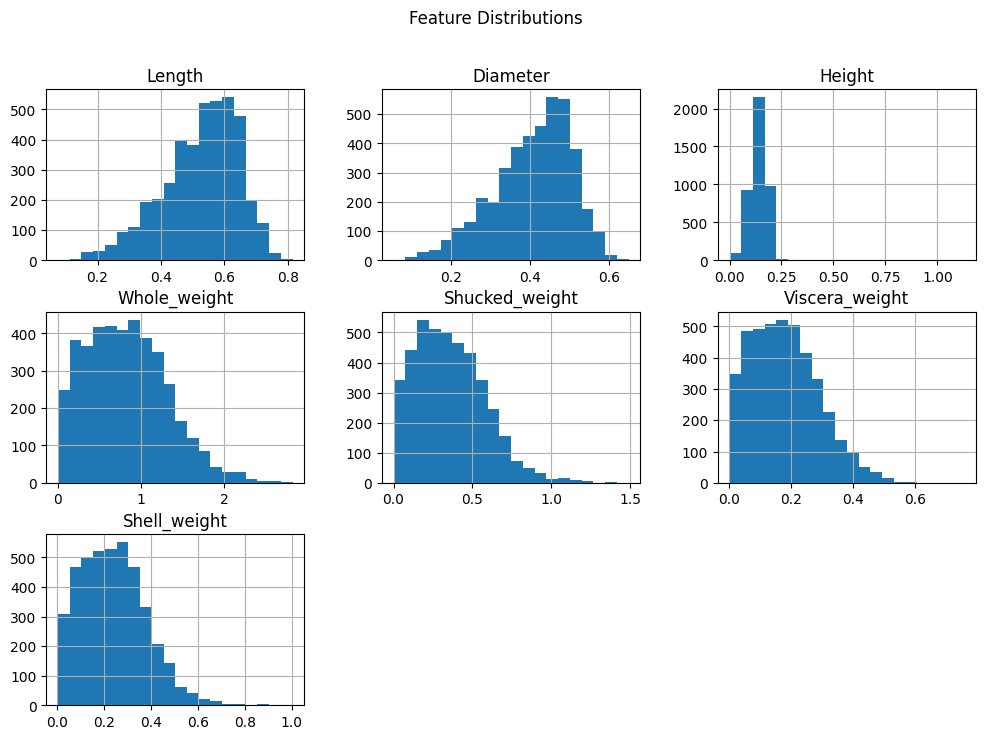

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

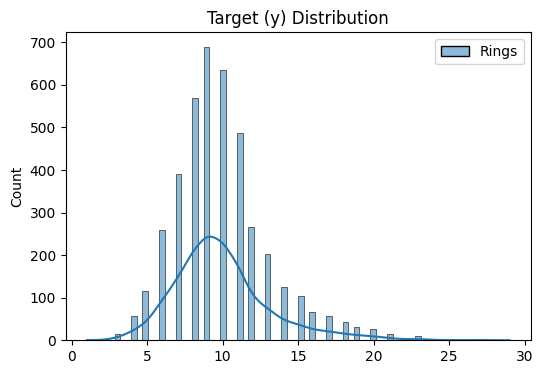

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

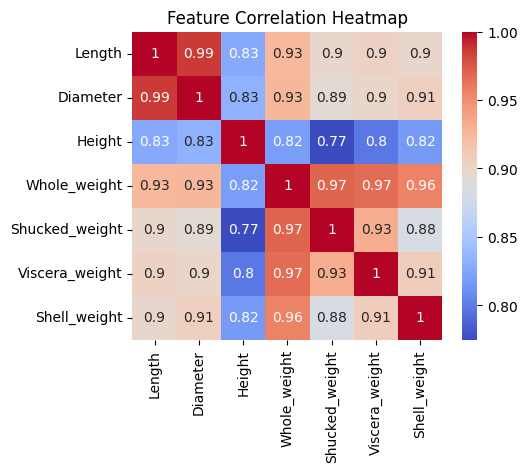

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.057686                 1.037880             1.231152   
1                  1.174123                 1.063846             1.163045   
2                  1.098995                 1.143248             1.154531   
3                  1.110907                 1.046162             1.246047   
4                  1.106171                 1.121132             1.077462   
mean               1.109576                 1.082454             1.174447   
std                0.041786                 0.047016             0.067592   

      DefaultBART_Rhat_RMSE  
0                  1.163824  
1                  1.243442  
2                  1.493233  
3                  1.149085  
4                  1.622816  
mean               1.334480  
std                0.212205  


In [ ]:
rhat_df.to_csv("results/real1_Abalone_rhat.csv", index=False)

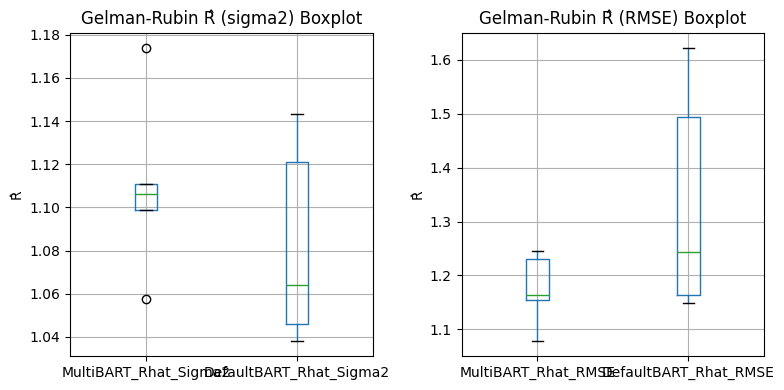

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      4.889129  4.979826  4.790290  4.758297  4.791655  5.722874
1      4.810238  4.901850  4.958048  4.964755  4.574730  5.348410
2      5.671929  5.451505  5.418731  5.461522  5.399027  5.810473
3      4.640815  4.576946  4.706126  4.600747  4.645710  5.385919
4      4.564228  4.558456  4.448307  4.341701  4.558238  5.046336
5      5.168043  5.049273  5.146351  5.021099  5.052298  5.874977
6      5.163106  4.962795  4.981633  5.327164  4.946810  5.660102
7      5.568879  5.401967  5.261707  5.525378  5.139162  5.571136
8      5.122881  4.938277  4.895960  4.933835  4.887725  5.738235
9      5.341585  5.295647  5.271661  5.345050  5.280333  5.807626
mean   5.094083  5.011654  4.987882  5.027955  4.927569  5.596609
std    0.371249  0.306065  0.295372  0.389380  0.292084  0.261880



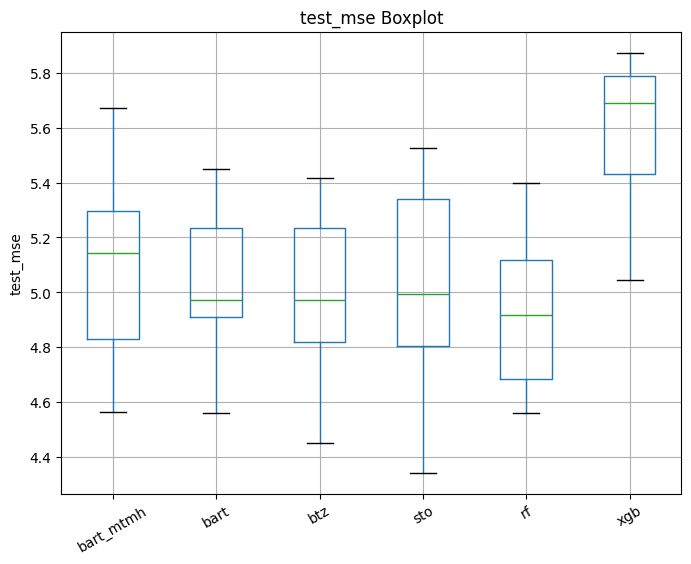

train_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      3.652557  4.108369  4.110281  4.540404  0.679427  0.542755
1      3.606934  4.190715  4.172296  4.638654  0.683244  0.606606
2      3.396956  4.007310  3.995134  4.211717  0.639765  0.543232
3      3.643685  4.180900  4.087740  4.513012  0.677036  0.545936
4      3.719314  4.160882  4.237827  4.396308  0.681703  0.621954
5      3.564085  3.998541  4.066868  4.367874  0.647193  0.533894
6      3.568259  4.180000  4.079494  4.494915  0.680122  0.566025
7      3.425142  3.961200  3.998993  4.434250  0.656752  0.540149
8      3.523136  4.100639  4.081152  4.418740  0.674107  0.535856
9      3.331156  3.930861  3.960968  4.412564  0.667631  0.549909
mean   3.543122  4.081942  4.079076  4.442844  0.668698  0.558632
std    0.124226  0.099134  0.083336  0.114636  0.015522  0.030849



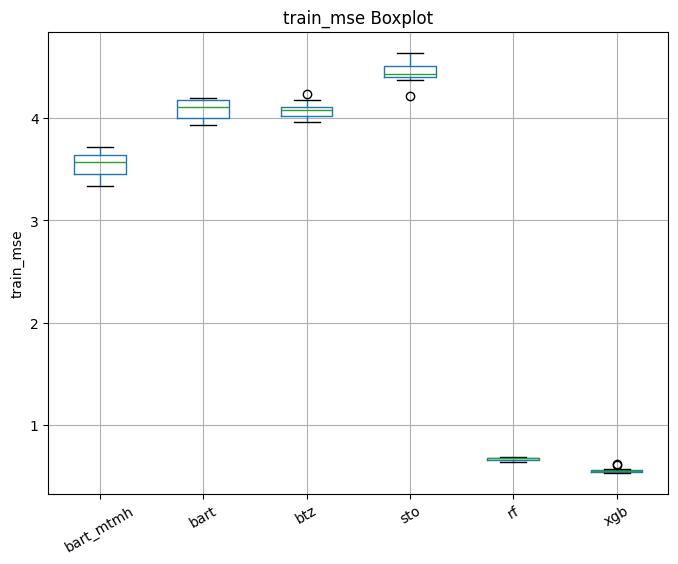

pi_length:
      bart_mtmh      bart       btz        sto
0      7.772203  7.899254  8.202017  17.953091
1      7.724539  7.962355  8.216651  18.980564
2      7.541557  7.785033  8.000296  17.075381
3      7.715841  7.979433  8.265559  17.980326
4      7.885173  7.936023  8.271406  17.870177
5      7.612288  7.824951  8.091166  17.794563
6      7.691868  7.975225  8.155495  17.896581
7      7.508412  7.842370  8.041359  17.092055
8      7.634488  7.918600  8.210474  17.384560
9      7.504817  7.707329  8.055357  17.777248
mean   7.659119  7.883057  8.150978  17.780455
std    0.122747  0.090629  0.097498   0.543601



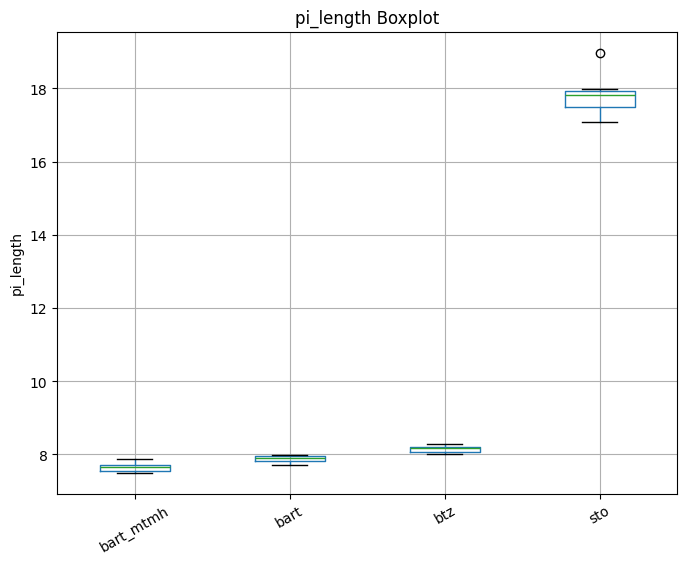

coverage:
      bart_mtmh      bart       btz       sto
0      0.929187  0.930144  0.935885  0.978947
1      0.911005  0.921531  0.925359  0.977033
2      0.902392  0.912919  0.917703  0.967464
3      0.916746  0.931100  0.940670  0.972249
4      0.927273  0.926316  0.936842  0.982775
5      0.911005  0.917703  0.918660  0.971292
6      0.908134  0.917703  0.919617  0.975120
7      0.907177  0.917703  0.911005  0.970335
8      0.916746  0.932057  0.937799  0.972249
9      0.917703  0.916746  0.921531  0.962679
mean   0.914737  0.922392  0.926507  0.973014
std    0.008588  0.006937  0.010413  0.005773



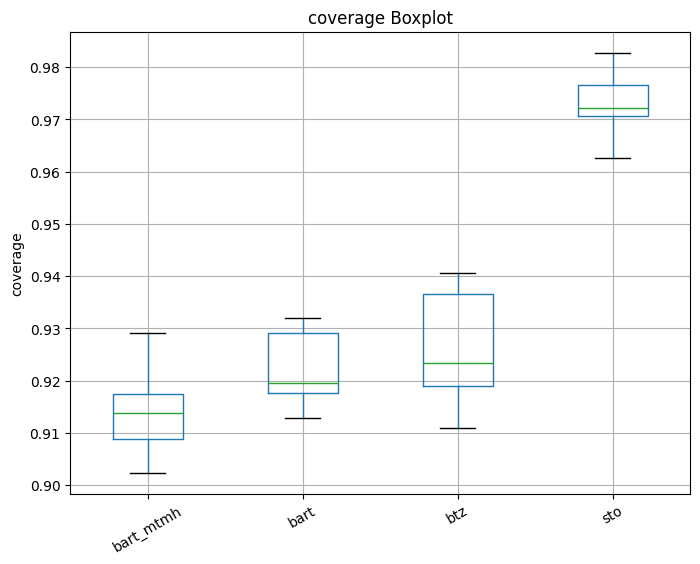

train_time:
      bart_mtmh      bart       btz       sto        rf       xgb
0     15.878937  1.845214  5.500126  3.496768  1.415005  0.187217
1     15.999669  1.783563  5.525555  3.432428  1.364575  0.218476
2     16.106241  1.801849  6.061754  3.394846  1.434656  0.177790
3     16.114850  1.852373  6.126587  3.249777  1.387068  0.162344
4     16.186641  1.854912  6.094365  3.316229  1.415827  0.183447
5     17.107097  1.842146  5.096717  4.043389  1.419710  0.150378
6     16.926363  1.859988  5.357731  3.888759  1.449324  0.127832
7     17.243234  1.821915  5.649891  3.446864  1.438662  0.129649
8     17.052326  1.884768  5.899132  3.295788  1.415582  0.144762
9     17.105766  1.938378  5.991329  3.221139  1.451605  0.136075
mean  16.572112  1.848511  5.730319  3.478599  1.419201  0.161797
std    0.553815  0.043118  0.355542  0.274091  0.027150  0.029539



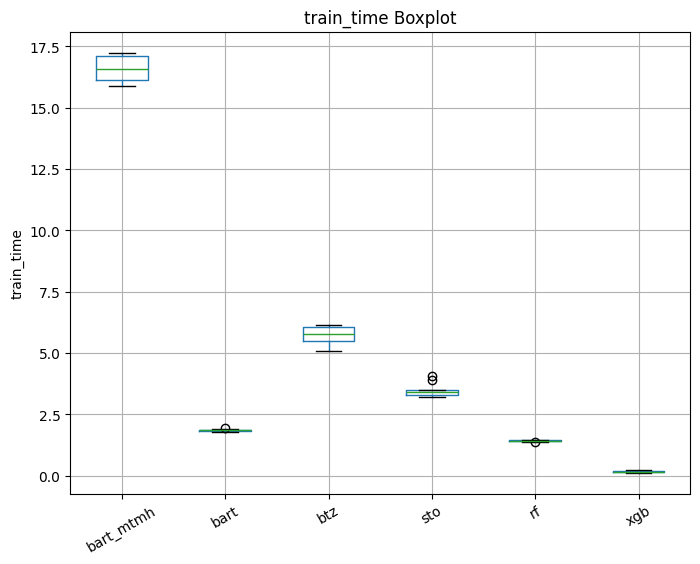

In [12]:
import matplotlib.pyplot as plt

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=100, n_post=100, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [ ]:
for k, v in mse_results.items():
    csv_name = f"results/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)